In [1]:
import torch
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation, add_salt_and_pepper_noise 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from mcmadaptablemodel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP
torch.manual_seed(1234)

# No noise

In [35]:
no_noise_model = MCMQuantumModel(qubits=8, layers=8, early_exits=[3])
no_noise_model.draw(style='sketch')

In [2]:
labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Lambda(lambda img: add_salt_and_pepper_noise(img, salt_prob=0.1, pepper_prob=0.1)),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

In [ ]:
mcm_accuracy, fm_accuracy, loss_history = no_noise_model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=50, show_plot=True)

In [14]:
"""import pickle

trained_params = no_noise_model.params
data = {
    'model_params': trained_params,
    'mcm_accuracy': mcm_accuracy,
    'fm_accuracy': fm_accuracy,
    'loss_history': loss_history
}

with open("/Users/jackvittori/Desktop/highnoise/traininghistory.pickle", "wb") as file:
    pickle.dump(data, file)"""

In [15]:
import pickle
with open("/Users/jackvittori/Desktop/lownoise/traininghistory.pickle", "rb") as file: 
    training_history = pickle.load(file)

In [16]:
loss_history = training_history['loss_history']
mcm_accuracy = training_history['mcm_accuracy']
fm_accuracy = training_history['fm_accuracy']
no_noise_mcm = training_history['model_params']

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plotting the loss on the first subplot
ax1.plot(list(range(50)), loss_history, marker='.', linestyle='-', color='b',
         label='Loss per Epoch')
ax1.set_title('Training Loss Over Epochs', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_xticks(list(range(0, 50, 2)))  # Mostra i tick ogni 5 epochs per ridurre la sovrapposizione
ax1.set_ylim(2.4, 2.8)  # Fissa la scala dell'asse y tra 2 e 3
ax1.legend()
ax1.grid(True)

# Plotting mcm_accuracy and fm_accuracy on the same plot (ax2)
ax2.plot(list(range(50)), mcm_accuracy, marker='.', linestyle='--', color='r',
         label='Mid circuit accuracy per epoch')
ax2.plot(list(range(50)), fm_accuracy, marker='.', linestyle='--', color='g',
         label='Final circuit accuracy per epoch')
ax2.set_title('Training Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.set_xticks(list(range(0, 50, 2)))  # Mostra i tick ogni 5 epochs per ridurre la sovrapposizione
ax2.set_ylim(0.20, 0.95)  # Fissa la scala dell'asse y tra 0.20 e 0.95
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.savefig('/Users/jackvittori/Desktop/lownoise/training010.png', dpi=300)
plt.show()

Evaluation utils

In [3]:
def early_evaluation_utils(params: Dict, state: torch.Tensor = None): 
    first_pair = [0,1]
    measurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
    
    for w in first_pair: 
        measurements.append(qml.measure(wires=w)) #measure first pair of qubits
    return measurements

def fully_evaluation_utils(params: Dict, state: torch.Tensor = None):
    first_pair = [0,1]
    second_pair = [2,3]
    mcasurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
            
    for w in first_pair: 
        mcasurements.append(qml.measure(wires=w)) #measure first pair of qubits

    for i in range(4, 8):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])

    for w in second_pair:
        mcasurements.append(qml.measure(wires=w))

    return mcasurements

dev = qml.device("default.qubit", wires=8)
@qml.qnode(dev)  
def early_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    early_measurement = early_evaluation_utils(params=params, state=state)
    return qml.probs(op=early_measurement)

@qml.qnode(dev)
def fully_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    measurements = fully_evaluation_utils(params=params, state=state)
    mid_measurement = measurements[:2]
    final_measurement = measurements[2:]
    return qml.probs(op=mid_measurement), qml.probs(op=final_measurement)

# Output probabilities distribution

In [26]:
early_probs_distribution = []
final_probs_distribution = []
for img, target in tqdm(validation_dataloader.dataset): 
    img = img / torch.linalg.norm(img).view(-1, 1)
    evaluation = fully_evaluation_ansatz(params=no_noise_mcm, state=img)
    early_full, final_full = evaluation
    
    early_prediction = torch.argmax(early_full, dim=1)
    early_probs = early_full[0, early_prediction].item()
    
    final_prediction = torch.argmax(final_full, dim=1)
    final_probs = final_full[0, final_prediction].item()
    
    early_probs_distribution.append(early_probs)
    final_probs_distribution.append(final_probs)    

In [27]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Creazione dell'istogramma per il primo array
ax.hist(early_probs_distribution, bins=60, density=False, alpha=0.5, color='g', edgecolor='black', label='Mid circuit probability distribution')

# Creazione dell'istogramma per il secondo array
ax.hist(final_probs_distribution, bins=60, density=False, alpha=0.5, color='r', edgecolor='black', label='final circuit probability distribution')

# Titolo e etichette degli assi
ax.set_title('Prediction confidence distribution', fontsize=16)
ax.set_xlabel('Prediction confidence', fontsize=14)
ax.set_ylabel('Occurrencies', fontsize=14)

# Aggiunta della legenda per distinguere le distribuzioni
ax.legend()

# Griglia e layout
ax.grid(True)
plt.tight_layout()

plt.savefig('/Users/jackvittori/Desktop/accuracyvsresources/probability_distribution_two_arrays.png', dpi=300)
plt.show()

# Evaluation with threshold

In [28]:
def evaluation_routine(dataloader: DataLoader, parameters: Dict, threshold: float):
    
    evaluation_results = []
    early_results = []
    count_1 = 0 #counter for early classified images
    count_2 = 0 #counter for final classified images
    early_correct = 0 #counter for correctly early classified images 
    final_correct = 0 #counter for correctly final classified images
    executed_layers = 0
    for img, target in dataloader.dataset:
        #img normalization
        img = img / torch.linalg.norm(img).view(-1, 1)
        
        #mid circuit evaluation
        early_probs = early_evaluation_ansatz(params=parameters, state=img)
        early_prediction = torch.argmax(early_probs, dim=1)
        confidence = early_probs[0, early_prediction].item()
        early_guess = early_prediction == target
        early_results.append(early_guess.item())
        
        if confidence >= threshold:
            evaluation_results.append(early_guess.item())
            count_1 += 1
            executed_layers += 4
            if early_guess: 
                early_correct += 1
            
        else: 
            final_probs = fully_evaluation_ansatz(params=parameters, state=img)
            early_full, final_full = final_probs
            final_predictions = torch.argmax(final_full, dim=1)
            final_guess = final_predictions == target
            evaluation_results.append(final_guess.item())
            count_2 += 1
            executed_layers += 12
            
            if final_guess: 
                final_correct += 1
    total_accuracy = sum([1 for i in evaluation_results if i == True])/len(evaluation_results)
    early_total_accuracy = sum([1 for i in early_results if i == True])/len(early_results)
    early_exited_accuracy = early_correct/count_1 if count_1 > 0 else 0
    final_exited_accuracy = final_correct/count_2 if count_2 > 0 else 0
    
    return total_accuracy, early_total_accuracy, early_exited_accuracy, count_1, final_exited_accuracy, count_2, executed_layers

In [29]:
def explain_evaluation(dataloader: DataLoader, parameters: Dict, threshold: List[float]):
    summary_data = {
    'Threshold': [],
    'Total Accuracy': [],
    '# early exited images': [],
    'Early exited Accuracy': [],
    'Early total accuracy': [],
    '# final classified images': [],
    'Final classified Accuracy': [],
    "Executed layers": []}
    
    for t in tqdm(threshold):
        total_accuracy, early_total_accuracy, early_exited_accuracy, count_1, final_exited_accuracy, count_2, executed_layers = evaluation_routine(dataloader, parameters, t)
        summary_data['Threshold'].append(t)
        summary_data['Total Accuracy'].append(total_accuracy)
        summary_data['# early exited images'].append(count_1)
        summary_data['Early exited Accuracy'].append(early_exited_accuracy)
        summary_data['Early total accuracy'].append(early_total_accuracy)
        summary_data['# final classified images'].append(count_2)
        summary_data['Final classified Accuracy'].append(final_exited_accuracy)
        summary_data['Executed layers'].append(executed_layers)
        
    df = pd.DataFrame(summary_data)
    return summary_data, df

In [31]:
summary, table = explain_evaluation(validation_dataloader, no_noise_mcm, thresholds)

In [32]:
"""import pickle

 """

E' strano ma le accuracy totali dopo una certa threshold variano solo delle cifre decimali successive

# Accuracy vs computational cost

In [1]:
import pickle
with open("/Users/jackvittori/Desktop/lownoise/evaluation01.pickle", "rb") as file: 
    evaluation_data = pickle.load(file)

In [2]:
summary = evaluation_data['summary']
table = evaluation_data['table']

In [3]:
computational_resource = summary['Executed layers']
error_rate = [(1-x)/(1-0.8095879342849448) for x in summary['Total Accuracy']]
computational_resource = [x/(3713*8) for x in computational_resource]

In [4]:
table

,Threshold,Total Accuracy,# early exited images,Early exited Accuracy,Early total accuracy,# final classified images,Final classified Accuracy,Executed layers
0,0.26,0.694587,3660,0.696448,0.691085,53,0.566038,15276
1,0.27,0.707783,3403,0.722892,0.691085,310,0.541935,17332
2,0.28,0.718826,2908,0.762036,0.691085,805,0.562733,21292
3,0.29,0.738217,2304,0.819010,0.691085,1409,0.606104,26124
4,0.30,0.748721,1758,0.869170,0.691085,1955,0.640409,30492
5,0.31,0.744412,1290,0.914729,0.691085,2423,0.653735,34236
6,0.32,0.741180,932,0.936695,0.691085,2781,0.675656,37100
7,0.33,0.738756,654,0.963303,0.691085,3059,0.690749,39324
8,0.34,0.735793,433,0.976905,0.691085,3280,0.703963,41092
9,0.35,0.734447,279,0.992832,0.691085,3434,0.713454,42324


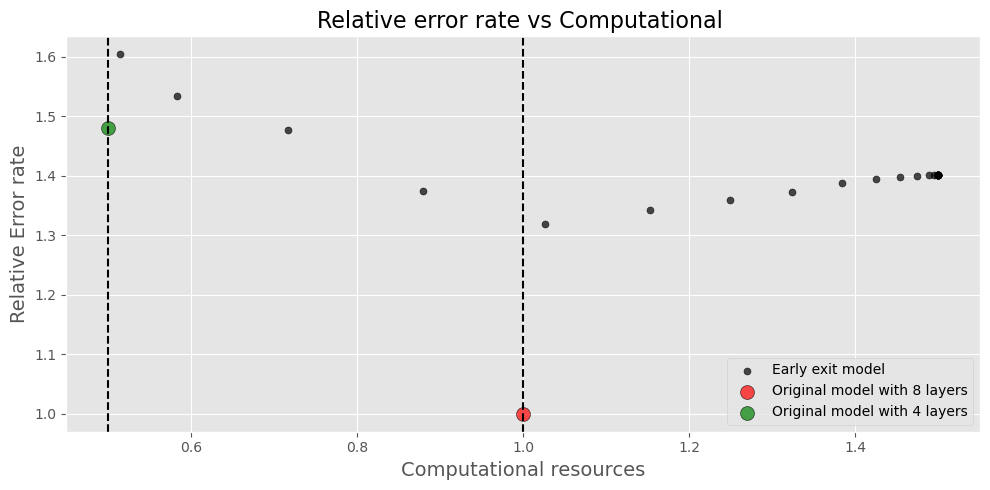

In [5]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Imposta lo stile 'ggplot'
fig, ax = plt.subplots(figsize=(10, 5))

# Creazione dello scatterplot principale
ax.scatter(computational_resource, error_rate, marker='.', color='black', alpha=0.7, edgecolor='black', s=100, label='Early exit model')

# Aggiunta di due punti con coordinate specifiche
ax.scatter(1, 1,  marker='o', color='r', alpha=0.7, edgecolor='black', s=100, label='Original model with 8 layers')  # Punto 1 (coordinate esempio 5, 0.9)
ax.scatter(0.5, (1-0.7182870993805548)/(1-0.8095879342849448),  marker='o', color='g', alpha=0.7, edgecolor='black', s=100, label='Original model with 4 layers')  # Punto 2 (coordinate esempio 10, 0.95)
ax.axvline(x=1, color='black', linestyle='--')
ax.axvline(x=0.5, color='black', linestyle='--')
# Titolo e assi
ax.set_title('Relative error rate vs Computational ', fontsize=16)
ax.set_xlabel('Computational resources', fontsize=14)
ax.set_ylabel('Relative Error rate', fontsize=14)

# Aggiunta della legenda con la nuova posizione
ax.legend(loc='lower right')  # Cambia la posizione della legenda

# Griglia e layout
ax.grid(True)
plt.tight_layout()

# Salvataggio dell'immagine
#plt.savefig('/Users/jackvittori/Desktop/highnoise/accvsres.png', dpi=300)
plt.show()

In [ ]:
LOW
sp = 0.1, 4 layer = 0.7182870993805548

sp = 0.1, 8 layer = 0.8095879342849448

MID
sp = 0.15, 4 layer = 0.6455696202531646

sp = 0.15, 8 layer = 0.7266361432803663

HIGH
sp = 0.2, 4 layer = 0.5704282251548612

sp = 0.2, 8 layer = 0.6506867761917586